## Imports

In [1]:
import scipy.io
import numpy as np
import math
from sklearn import linear_model 
from scipy import linalg
from sklearn import preprocessing as preproc # load preprocessing function
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from sklearn.model_selection import KFold

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [2]:
mat = scipy.io.loadmat('sand.mat')

X = mat['X']
y = mat['Y']

[n,p] = X.shape

### 1 Apply Least angle regression and selection (LARS) for the p >> n sand data set (X: data matrix with 59 observations and 2016 features, y: the measured moisture content in percent for each sand sample). Find a suitable solution using:

>(a) The Cp statistic. Consider whether the Cp-statistic makes sense in this case (p > n). Why? Why not?

>> (i) Hint: What happens to your estimate of the noise in the data?

In [3]:
# Estimate the noise of the data
# Calculate an unbiased OLS estimate using linalg.lstsq

#p is the number of features 
# sigma squared
# 
betas, res, rnk, s = linalg.lstsq(X, y)
y_ols = X@betas
sigma2 = np.mean((y-y_ols)**2)
print(sigma2) 
# wiki says. lars is effective when p>n. 

1.2256850754698749e-24


>(b) Using Cross-validation. Remember to center y and normalize X, but do it inside
the cross validation!

In [4]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def normalizeData(data):
    
    data, mu = centerData(data)
    std = np.std(data, axis=0)
    data = data/std
    
    return data, mu, std

# Set up cross validation like you did last week
CV = 5 # if K = n leave-one-out, you may try different numbers
kf = KFold(n_splits=CV)

# Set a suitable range of features that can be given to LARS as n_nonzero_coefs 
stop = n-math.ceil(n/CV)
K = range(1,stop)

Err_tr = np.zeros((CV,len(K)))
Err_tst = np.zeros((CV, len(K))) 
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].ravel(), y[test_index].ravel()
    
    X_train, mu, std = normalizeData(X_train)
    X_test, mu, std = normalizeData(X_test)

    y_train, _ = centerData(y_train)
    y_test, _ = centerData(y_test)

    for k in K:
    # compute all LARS solutions inside each fold 
        clf = linear_model.Lars(n_nonzero_coefs=k, fit_path = False, fit_intercept = False, verbose = True)
        clf.fit(X_train, y_train)
        betas = clf.coef_.ravel()

        # Predict with this model, and find both training and test error
        YhatTr = X_train @ betas
        YhatTest = X_test @ betas
        
        Err_tr[i,k-1] = np.mean((YhatTr-y_train)**2)
        Err_tst[i,k-1] = np.mean((YhatTest-y_test)**2)

err_tr = np.mean(Err_tr, axis=0) # mean training error over the CV folds
err_tst = np.mean(Err_tst, axis=0) # mean test error over the CV folds
err_ste = np.std(Err_tst, axis=0)/np.sqrt(CV) # Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation

print(err_tr[-5:])
print(err_tst[-5:])
print(err_ste[-5:])

[ 72.12790132  79.96292604  89.99869043  98.02593437 109.90715314]
[ 6016.27902933  7612.50460286  9518.96390493 13125.49415601
 17552.73764465]
[2182.80280361 2208.69964426 2645.70190659 4973.805422   5700.30087936]


In [5]:
# Compute Cp-statistic, assumption n > p
x_norm, mu_x, std_x = normalizeData(X)
X_norm = (X - mu_x)/std_x
y_norm, mu_y = centerData(y)
y_norm = y_norm - mu_y


# run LARS on all data and and vary the nonzero coefs from 0 to p. save the betas for Cp
Betas = np.zeros((p, n))
for j in range(1,n):
    reg = linear_model.Lars(n_nonzero_coefs=j)
    reg.fit(X_norm,y)
    Betas[:,i] = reg.coef_

# calculate Cp for each number of nonzero coefs
Cp = np.zeros((len(K)))
for j in range(len(K)):
    Yhat = X_norm @ Betas[:,K[j]]
    Cp[j] = np.mean(((y-Yhat)**2)) + 2*K[j]/n*sigma2

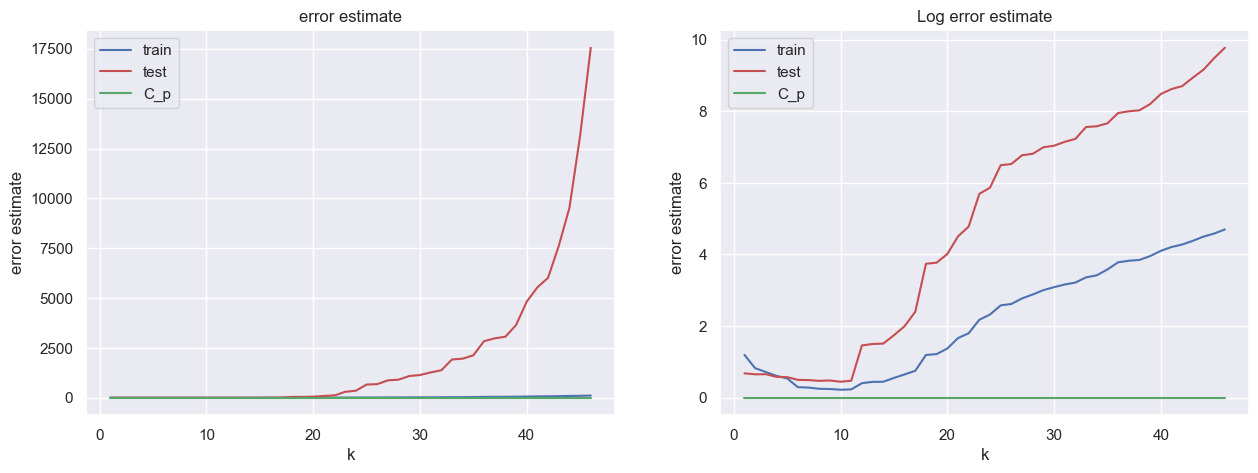

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,5))    
ax[0].plot(K, err_tr, 'b', label='train')
ax[0].plot(K, err_tst, 'r', label='test')
ax[0].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[0].legend()
ax[0].set_xlabel('k')
ax[0].set_ylabel('error estimate')
ax[0].set_title("error estimate")

ax[1].plot(K, np.log(err_tr), 'b', label='train')
ax[1].plot(K, np.log(err_tst), 'r', label='test')
ax[1].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[1].legend()
ax[1].set_xlabel('k')
ax[1].set_ylabel('error estimate')
ax[1].set_title("Log error estimate")
plt.show()